# Small-Cap Stock Price Movement Prediction

#### Author: Jake Oddi

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from td.client import TDClient
import requests
import json
import time
from config import ameritrade_credentials 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
np.random.seed(seed = 1)

## Overview

This project applies classification methods to the daily price data of stocks with market capitalizations between \\$75M and \\$1B from the past three years to predict intraday price movements. Instances where the closing price exceeds the opening price are considered positive cases, and instances where the opposite is true are considered negative.

## Business Problem

Quantitative analysis of stocks has become increasingly popular over the past decades, to the point where it is ubiqiutous among insitutional investors. Among individual investors, however, it is less widespread. This is due to a general lack of the technical skills required to perform such analysis. I ran into this issue myself when constructing my portfolio. I predict an easy-to-use, open-source model would serve to benefit this population. 

My analysis focuses on small-cap companies because they typically see lower trading volumes, and therefore have more inefficiencies that can be exploited. Conversely, this makes trades harder to execute at desirable prices. 

Predictions of price-movement-direction are nowhere near perfect, and should only be used in conjunction with additional information.

## Data Understanding

### Data Acquisition

To decide which companies to model, I employed a stock screener from [TD Ameritrade](https://research.tdameritrade.com/grid/public/screener/stocks/overview.asp) to select stocks with market caps within my desired range. This yielded 8027 results. I filtered this down to 3055 results by removing companies worth less than \\$75M, as many companies below that threshold had such low trading volumnes that they were not conducive to modeling. For the sake of ease-of-use and proof-of-concept, I filtered this down further by randomly sampling 500. I then gathered daily price data from the past three years using [TD Ameritrade's Price History API](https://developer.tdameritrade.com/price-history/apis). Of these 500, the API failed for 157, leaving 343. Of the remaining, I selected only those with more than 200 days of data to use in my analysis, leaving me with 282 stocks. 

In [5]:
# Read in the screener
screen = pd.read_csv('ameritrade_stock_screener.csv', header = 0)

#### Screener Cleaning

In [9]:
# Rename screener columns
screen.columns = ['ticker', 'company', 'market_cap', 'sector', 'industry', 'dividend_yield', 'beta']

# Screening only for companies worth > $75M
screen = screen[screen['market_cap'] >= 75000000]

#### Selection

In [12]:
# Instantiate a list of 500 random integers for selection of df indices from the screener
rand_list = np.random.randint(0, screen.shape[0], 500)

# Filter the screener using the list of random indices
filtered_screen = screen.iloc[rand_list]

# Create a list of the tickers of all stocks selected by the filter
ticker_list = filtered_screen['ticker'].values

#### API Call - Configuration

In [15]:
# Import personal client ID
client_id = ameritrade_credentials.consumer_key

# Set payload params
period = '3'
period_type = 'year'
frequency = '1'
frequency_type = 'daily'
start_date = '1512172799'
end_date = '1606867199'

# Define payload
payload = {'apikey': client_id,
           'periodType': period_type,
           'frequencyType': frequency_type,
           'frequency': frequency,
           'period': period,
#            'endDate': end_date,
#            'startDate': start_date,
           'needExtendedHoursData': 'false'
          }

#### API Call

In [17]:
def get_data_from_ameritrade(ticker_list, payload):
    """
    Takes in list of tickers and payload and returns complete dataframe with all 
    tickers and prices.
    
    ticker_list -- array of strings containing n number of tickers
    payload -- dictionary containing parameters for API call
    
    """
    df_list = []
    fail_cache = []
    payload = payload
    for ticker in ticker_list:
        # Define endpoint
        endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(ticker)
        
        try:
            # Make Request
            content = requests.get(url = endpoint, params = payload)

            # Convert to dataframe
            data = content.json()
            data = pd.DataFrame(data = data['candles'])
            data['ticker'] = ticker

            # Append to list of dataframes
            df_list.append(data)
            
        except:
            # Append problematic ticker to list of failed tickers
            fail_cache.append(ticker)
            continue
    
    return df_list, fail_cache

In [18]:
# A list of dfs is instantiated, where each stock's data is stored in a dataframe
df_list, fail_cache = get_data_from_ameritrade(ticker_list, payload)

In [ ]:
print('Length of df_list:', len(df_list))
print('Length of fail_cache', len(fail_cache))

### Understanding

The API returned a dataframe with the following columns built in for each stock: opening price, daily high, daily low, closing price, datetime, volume, and ticker.

In [202]:
df_list[0].head()

,open,high,low,close,volume,ticker,10_day_ma,50_day_ma,200_day_ma,intra_clf_target,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2017-12-14 06:00:00,19.70,19.85,18.90,18.95,273745,FRGI,18.950000,18.950000,18.950000,0,0,0,0,0
2017-12-15 06:00:00,18.95,19.55,18.95,19.30,487634,FRGI,19.142500,19.128500,19.125875,1,0,0,0,0
2017-12-18 06:00:00,19.45,19.80,19.20,19.30,156552,FRGI,19.205814,19.187968,19.184498,0,0,0,0,0
2017-12-19 06:00:00,19.25,19.55,19.20,19.35,126489,FRGI,19.253317,19.230938,19.226496,1,0,0,0,0
2017-12-20 06:00:00,19.50,19.60,18.95,19.05,149596,FRGI,19.194950,19.191799,19.190487,0,0,0,0,0


#### Further Filtering

In [ ]:
df_list = list(filter(lambda x: x.shape[0] > 200, df_list))

In [ ]:
len(df_list)

## Modleing and Results

## Conclusion and Next Steps

In [6]:
screen.head()

,Symbol,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta
0,AAAIF,ALTERNATIVE INVESTMENT TRUST UNITS,2.856715e+07,NaN,NaN,--,+0.2
1,AACG,ATA Creativity Global(ADR),3.713346e+07,Consumer Discretionary,Diversified Consumer Services,--,+1.7
2,AACH,AAC Holdings Inc,4.025300e+05,Health Care,Health Care Providers & Services,--,+2.7
3,AACQ,Artius Acquisition Inc,9.341573e+08,NaN,NaN,--,--
4,AACS,"American Commerce Solutions, Inc.",6.946900e+05,Industrials,Road & Rail,--,-1.0


In [7]:
screen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8027 entries, 0 to 8026
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Symbol                 8027 non-null   object 
 1   Company Name           8027 non-null   object 
 2   Market Capitalization  8027 non-null   float64
 3   Sector                 5348 non-null   object 
 4   Industry               5348 non-null   object 
 5   Dividend Yield         8027 non-null   object 
 6   Beta                   8027 non-null   object 
dtypes: float64(1), object(6)
memory usage: 439.1+ KB


In [197]:
screen['market_cap'].value_counts()

100000000.0    2
394264430.0    1
420106500.0    1
273312240.0    1
437836080.0    1
              ..
140558000.0    1
657100890.0    1
82137560.0     1
186295000.0    1
268435950.0    1
Name: market_cap, Length: 3054, dtype: int64

<AxesSubplot:ylabel='Frequency'>

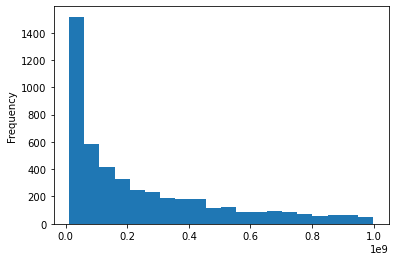

In [30]:
screen['market_cap'].plot(kind = 'hist', bins = 20)

### Inspection

In [21]:
len(df_list)

343

In [123]:
len_list = []
for df in df_list:
    len_list.append(df.shape[0])
    

In [124]:
len_list

[755,
 755,
 755,
 276,
 481,
 755,
 120,
 138,
 755,
 357,
 755,
 755,
 755,
 755,
 755,
 305,
 755,
 142,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 754,
 755,
 622,
 642,
 755,
 755,
 674,
 755,
 467,
 755,
 755,
 754,
 755,
 114,
 341,
 755,
 325,
 642,
 755,
 755,
 755,
 755,
 755,
 755,
 249,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 621,
 755,
 377,
 755,
 539,
 755,
 755,
 755,
 115,
 755,
 755,
 755,
 607,
 687,
 755,
 755,
 754,
 325,
 755,
 755,
 755,
 555,
 755,
 743,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 150,
 755,
 755,
 274,
 755,
 755,
 350,
 755,
 317,
 755,
 755,
 755,
 755,
 755,
 755,
 670,
 755,
 153,
 755,
 643,
 755,
 755,
 721,
 508,
 356,
 630,
 220,
 730,
 755,
 755,
 487,
 755,
 755,
 754,
 755,
 558,
 755,
 529,
 755,
 755,
 755,
 755,
 202,
 335,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 755,
 647,
 747,
 755,
 755,
 755,
 755,
 753,
 562,
 755,
 755,
 755,
 755,
 755,
 451,
 755,
 755,
 755,
 305,
 308,
 755,
 126

In [199]:
list(filter(lambda x: x.shape[0] > 200, df_list))

[                      open     high      low  close  volume ticker  10_day_ma  \
 datetime                                                                        
 2017-12-14 06:00:00  19.70  19.8500  18.9000  18.95  273745   FRGI  18.950000   
 2017-12-15 06:00:00  18.95  19.5500  18.9500  19.30  487634   FRGI  19.142500   
 2017-12-18 06:00:00  19.45  19.8000  19.2000  19.30  156552   FRGI  19.205814   
 2017-12-19 06:00:00  19.25  19.5500  19.2000  19.35  126489   FRGI  19.253317   
 2017-12-20 06:00:00  19.50  19.6000  18.9500  19.05  149596   FRGI  19.194950   
 ...                    ...      ...      ...    ...     ...    ...        ...   
 2020-12-08 06:00:00  12.69  13.5100  12.6501  13.08  155741   FRGI  12.504510   
 2020-12-09 06:00:00  13.11  13.5800  12.9300  13.04  162620   FRGI  12.601872   
 2020-12-10 06:00:00  12.84  12.8774  12.3300  12.64  123167   FRGI  12.608804   
 2020-12-11 06:00:00  12.48  12.7600  12.3100  12.42   97892   FRGI  12.574476   
 2020-12-14 06:0

In [200]:
len(df_list)

282

<AxesSubplot:ylabel='Frequency'>

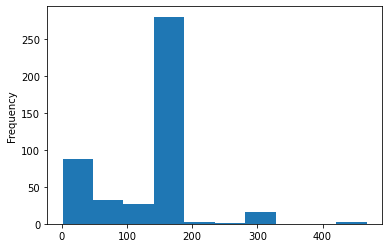

In [54]:
# Hist showing distribution of entry frequency in data

df['ticker'].value_counts().plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

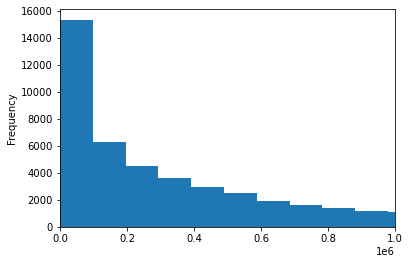

In [68]:
df['volume'].plot(kind = 'hist', xlim = (0,1000000), bins = 10000)

In [69]:
df['volume'].mean()

2013695.1376984685

## Cleaning

In [ ]:
df_list = list(filter(lambda x: x.shape[0] > 200, df_list))

In [67]:
# Date Cleaning
def clean_dates(df_list):
    for df in df_list:
        # Convert from unix to year month day format
        df['datetime'] = pd.to_datetime(df['datetime'], unit = 'ms')

        # Set datetime as index
        df.set_index(df['datetime'], inplace = True)

        # Drop original datetime column
        df.drop(columns = 'datetime', inplace = True)
        
    return df_list

In [68]:
clean_dates(df_list)

KeyError: 'datetime'

## Feature Engineering

In [69]:
def create_moving_avs(df_list):
    """
    Takes in list of dfs, creates three different moving average 
    features - 10, 50, and 200 days.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['10_day_ma'] = df['close'].ewm(span = 10).mean()
        df['50_day_ma'] = df['close'].ewm(span = 50).mean()
        df['200_day_ma'] = df['close'].ewm(span = 200).mean()
     
    return df_list

df_list = create_moving_avs(df_list)

In [80]:
def create_intra_clf_target(df_list):
    """
    Takes in list of dfs and creates target variable for each depending
    on if the closing price for each day exceeds the opening price. If the
    closing price exceeds the opening price, target = 1.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['intra_clf_target'] = 0
        for i in range(len(df)):
            
            if df['open'][i] < df['close'][i]:
                df['intra_clf_target'][i] = 1
            
            elif df['open'][i] > df['close'][i]:
                df['intra_clf_target'][i] = 0
    
            elif df['open'][i] == df['close'][i]:
                df['intra_clf_target'][i] = 2
    
    return df_list

df_list = create_intra_clf_target(df_list)

In [179]:
def create_pct_price_changes(df_list):
    """
    Takes in a list of dfs and creates price change (%) features with various
    intervals.
    Calculates % price changes relative to the day before observed date to 
    prediction using unknown data.
    
    df_list -- list of dfs
    """
    # Creating i_day_pct_change columns in each df
    for df in df_list:
        df['1_day_pct_change'] = 0
        df['2_day_pct_change'] = 0
        df['3_day_pct_change'] = 0
        df['4_day_pct_change'] = 0
   
        # Calculating ith day price change for each col
        for i in range(5, df.shape[0]):
            # Difference in closing prices between the previous day and the previous day
            diff = float(df['close'][i-1]) - float(df['close'][i-2])
            pct = (float(diff)/float(df['close'][i-2])) * 100
            df['1_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and two days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-3])
            pct = (float(diff)/float(df['close'][i-3])) * 100
            df['2_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and three days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-4])
            pct = (float(diff)/float(df['close'][i-4])) * 100
            df['3_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and four days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-5])
            pct = (float(diff)/float(df['close'][i-5])) * 100
            df['4_day_pct_change'][i] = pct
            

In [180]:
create_pct_price_changes(df_list)

<ipython-input-179-86d2943f1357>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['1_day_pct_change'][i] = pct
<ipython-input-179-86d2943f1357>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2_day_pct_change'][i] = pct
<ipython-input-179-86d2943f1357>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_day_pct_change'][i] = pct
<ipython-input-179-86d2943f1357>:35: SettingWithCopyWarning: 
A value is trying to be set on a

In [181]:
df_list[0]

,open,high,low,close,volume,ticker,10_day_ma,50_day_ma,200_day_ma,intra_clf_target,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2017-12-14 06:00:00,19.70,19.8500,18.9000,18.95,273745,FRGI,18.950000,18.950000,18.950000,0,0,0,0,0
2017-12-15 06:00:00,18.95,19.5500,18.9500,19.30,487634,FRGI,19.142500,19.128500,19.125875,1,0,0,0,0
2017-12-18 06:00:00,19.45,19.8000,19.2000,19.30,156552,FRGI,19.205814,19.187968,19.184498,0,0,0,0,0
2017-12-19 06:00:00,19.25,19.5500,19.2000,19.35,126489,FRGI,19.253317,19.230938,19.226496,1,0,0,0,0
2017-12-20 06:00:00,19.50,19.6000,18.9500,19.05,149596,FRGI,19.194950,19.191799,19.190487,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-08 06:00:00,12.69,13.5100,12.6501,13.08,155741,FRGI,12.504510,10.948679,9.562365,1,-1,-1,4,5
2020-12-09 06:00:00,13.11,13.5800,12.9300,13.04,162620,FRGI,12.601872,11.030691,9.596987,0,1,0,0,5
2020-12-10 06:00:00,12.84,12.8774,12.3300,12.64,123167,FRGI,12.608804,11.093801,9.627282,0,0,1,0,0


## Modeling

In [194]:
def time_train_test_split(df_list, split_date):
    """
    Takes in a list of dfs and a date to split train and test sets
    on the split date and returns X_train, X_test, y_train, y_test.
    
    df_list -- list of dfs
    split_date -- str formatted as 'YYYY-MM-DD'
    """
    
    for df in df_list:
        train_test_sets = []
        

In [ ]:
def plant_random_forests(df_list):
    """
    Takes in a list of dfs, runs a Random Forest Classifier on each,
    then returns a list of true y train and test values, as well as 
    predicted y train and test values.
    
    df_list -- list of dfs
    """
    scaler = StandardScaler()
    
    

In [ ]:
def time_cross_validate():
    pass

# Model Test

In [196]:
df_test = df_list[0]
df_test.head(25)

,open,high,low,close,volume,ticker,10_day_ma,50_day_ma,200_day_ma,intra_clf_target,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2017-12-14 06:00:00,19.70,19.850,18.9000,18.95,273745,FRGI,18.950000,18.950000,18.950000,0,0,0,0,0
2017-12-15 06:00:00,18.95,19.550,18.9500,19.30,487634,FRGI,19.142500,19.128500,19.125875,1,0,0,0,0
2017-12-18 06:00:00,19.45,19.800,19.2000,19.30,156552,FRGI,19.205814,19.187968,19.184498,0,0,0,0,0
2017-12-19 06:00:00,19.25,19.550,19.2000,19.35,126489,FRGI,19.253317,19.230938,19.226496,1,0,0,0,0
2017-12-20 06:00:00,19.50,19.600,18.9500,19.05,149596,FRGI,19.194950,19.191799,19.190487,0,0,0,0,0
2017-12-21 06:00:00,19.15,19.400,18.9000,19.30,207587,FRGI,19.222235,19.211683,19.209199,1,-1,-1,-1,0
2017-12-22 06:00:00,19.35,19.400,19.0250,19.25,254137,FRGI,19.228925,19.217835,19.215204,0,1,0,0,0
2017-12-26 06:00:00,19.25,19.450,19.0500,19.30,115539,FRGI,19.245095,19.229600,19.226178,1,0,1,0,0
2017-12-27 06:00:00,19.35,19.350,18.9000,19.10,222243,FRGI,19.213528,19.212791,19.211591,0,0,0,1,0


In [183]:
train = df_test[:'2020-02-02']
test = df_test['2020-02-02':]

In [184]:
X_train, y_train = train[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], train['intra_clf_target']

In [185]:
X_test, y_test = test[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], test['intra_clf_target']

In [186]:
knn = KNeighborsClassifier()

In [187]:
scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-1.05918567, -1.23663462, -1.74993525, ..., -1.38906052,
        -1.53726146, -1.50716024],
       [-1.06575776, -1.23658054, -1.75270235, ..., -0.81959893,
        -1.08487703, -1.31281685],
       [-1.06672552, -1.23550453, -1.75507287, ...,  0.60405506,
        -0.18010819, -0.53544329],
       ...,
       [-0.7241594 , -1.08285111, -2.14956799, ...,  0.31932426,
         0.04608402,  0.04758689],
       [-0.72936261, -1.07436299, -2.1431572 , ..., -0.81959893,
        -0.4063004 , -0.53544329],
       [-0.73610007, -1.06678377, -2.13701687, ..., -1.10432973,
        -1.08487703, -0.53544329]])

In [188]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [189]:
preds = knn.predict(X_test)

In [190]:
accuracy_score(y_test, preds) # improved from .45

0.4863636363636364

In [191]:
precision_score(y_test, preds, average = 'weighted') # improved from .44

C:\Users\David\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4816861244019139

In [192]:
recall_score(y_test, preds, average = 'weighted')

0.4863636363636364

## Failed Tests

In [33]:
endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format('RKFL')

## Insurance

In [34]:
# Make Request
content = requests.get(url = endpoint, params = payload)

# Convert to dictionary
data = content.json()

In [35]:
data

{'candles': [{'open': 8.25,
   'high': 8.25,
   'low': 8.25,
   'close': 8.25,
   'volume': 175,
   'datetime': 1531717200000},
  {'open': 8.5,
   'high': 8.5,
   'low': 8.5,
   'close': 8.5,
   'volume': 100,
   'datetime': 1532926800000},
  {'open': 8.5,
   'high': 9.0,
   'low': 8.5,
   'close': 9.0,
   'volume': 500,
   'datetime': 1534136400000},
  {'open': 9.75,
   'high': 9.75,
   'low': 9.75,
   'close': 9.75,
   'volume': 100,
   'datetime': 1540789200000},
  {'open': 9.75,
   'high': 9.75,
   'low': 9.0,
   'close': 9.0,
   'volume': 205,
   'datetime': 1542002400000},
  {'open': 8.8,
   'high': 8.8,
   'low': 8.0,
   'close': 8.0,
   'volume': 500,
   'datetime': 1542607200000},
  {'open': 5.0,
   'high': 5.0,
   'low': 4.0,
   'close': 4.0,
   'volume': 400,
   'datetime': 1545026400000},
  {'open': 4.0,
   'high': 4.0,
   'low': 4.0,
   'close': 4.0,
   'volume': 290,
   'datetime': 1545631200000},
  {'open': 1.11,
   'high': 6.0,
   'low': 1.11,
   'close': 6.0,
   'volum

In [36]:
test_df = pd.DataFrame(data = data['candles'])

In [37]:
test_df

,open,high,low,close,volume,datetime
0,8.250,8.250,8.2500,8.250,175,1531717200000
1,8.500,8.500,8.5000,8.500,100,1532926800000
2,8.500,9.000,8.5000,9.000,500,1534136400000
3,9.750,9.750,9.7500,9.750,100,1540789200000
4,9.750,9.750,9.0000,9.000,205,1542002400000
5,8.800,8.800,8.0000,8.000,500,1542607200000
6,5.000,5.000,4.0000,4.000,400,1545026400000
7,4.000,4.000,4.0000,4.000,290,1545631200000
8,1.110,6.000,1.1100,6.000,550,1547445600000
9,6.250,8.000,6.0000,6.000,2488,1550469600000
